# Jupyter Notebook that trains various ML models to detect bugs in code and then evaluates and compares their performance

# Installs Necessary Modules

In [1]:
!pip3 install -U keras-tuner
!pip3 install -U tensorflow
!pip3 install -U tensorflow-text

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to u

# Imports Necessary Library Functions from Modules

In [2]:
import collections
import pathlib
import re
import string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import pandas as pd
import sklearn
import os
import re
import ast
import shutil

# Helper Functions that Induce Bugs

In [3]:
# removes the first instance of the outermost parentheses in a line
# if possible
# eg: removeOuterParentheses('print (x + y)') = 'print x + y'
# removeOuterParentheses('(x / y) + (z * a)') = 'x / y + (z * a)'
def removeOuterParentheses(S: str) -> str:
    COUNT = 0
    START = 0
    RES = ''
    STARTED = False
    END = 0
    for i in range(len(S)):
        
        if (S[i] == '('):
            COUNT += 1
            if STARTED == False:
                START = i
                RES += S[:i]
                STARTED = True
            
        elif (S[i] == ')'): 
            COUNT -= 1
        
        if ((COUNT == 0) and (STARTED == True)):                
            RES += S[START+1 : i]
            RES += S[i+1:]
            break
            # START += i+1
            # END = i
    if ((RES == S) or (RES == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, RES, 'Missing_Outermost_Parenthesis')


# swaps a comparison operator (if present) in a line with the opposite comparison
# i.e. < becomes >, >= becomes <=. == is changed to = 
def swapComparison(S: str) -> str:
    swapped = ''
    if '<' in S:
        swapped = S.replace('<', '>')
    elif '>' in S:
        swapped = S.replace('>', '<')
    elif '<=' in S:
        swapped = S.replace('<=', '>=')
    elif '>=' in S:
        swapped = S.replace('>=', '<=')
    elif '==' in S:
        swapped = S.replace('==', '=')
    # if RES == S - return false
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Incorrect_Comparison')

# swaps a comparison operator (if present) in a line with a comparison operator
# that will create an off by one error. eg: <= becomes <
def offByOne(S: str) -> str:
    swapped = ''
    if '<' in S:
        swapped = S.replace('<', '<=')
    elif '>' in S:
        swapped = S.replace('>', '>=')
    elif '<=' in S:
        swapped = S.replace('<=', '<')
    elif '>=' in S:
        swapped = S.replace('>=', '>')
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Off_by_One')

# increases the indent of a line by one space
def increaseIndent(S: str) -> str:
    swapped = ' ' + S
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Extra_Indentation')

# decreases the indent of a line (if possible) by one space
def decreaseIndent(S: str) -> str:
    swapped = ''
    if S[0] == ' ':
        swapped = S[1:]
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Less_Indentation')
    
# increases the argument count of a function call - excluding print() and function definitions
# such that the first argument is added again at the end (if possible)
def increaseArgCount(S: str) -> str:
    new_string = ''
    if ('def' not in S) and ('print' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            index_end = S.find(')')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_end] + ', ' + S[index_start+1:index_comma] + S[index_end:]
            else:
                new_string = S[0:index_end] + ', ' + S[index_start+1:]
        elif ('[' in S) and (']' in S):
            index_start = S.find('[')
            index_end = S.find(']')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_end] + ', ' + S[index_start+1:index_comma] + S[index_end:]
            else:
                new_string = S[0:index_end] + ', ' + S[index_start+1:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Extra_Argument')

# decreases the argument count of a function call - excluding print() and function definitions
# such that the last argument is no longer present (if possible)
def decreaseArgCount(S: str) -> str:
    new_string = ''
    if ('def' not in S) and ('print' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            index_end = S.find(')')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_start+1] + S[index_comma+1:]
            else:
                new_string = S[0:index_start+1] + S[index_end:]
        elif ('[' in S) and (']' in S):
            index_start = S.find('[')
            index_end = S.find(']')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                new_string = S[0:index_start+1] + S[index_comma+1:]
            else:
                new_string = S[0:index_start+1] + S[index_end:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Less_Arguments')

# removes a function call (if possible) leaving just the variables present with a tuple
def removeFunctionCall(S: str) -> str:
    new_string = ''
    if ('def' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            temp_string = S[:index_start]
            flip_temp_string = temp_string[::-1]
            length_function_call = flip_temp_string.find(' ')
            if (length_function_call == 0):
                temp_string = S[:index_start - 1]
                flip_temp_string = temp_string[::-1]
                length_function_call = flip_temp_string.find(' ')
            # what if someone puts a space between function call and foo (x+y) - have to account for this
            if (length_function_call != -1):
                new_string = S[:index_start-length_function_call] + S[index_start:]
            else:
                new_string = S[index_start:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Missing_Function_Call')


# swaps the first two arguments of a function call (if possible)
# excluding function definitions
def swapArguments(S: str) -> str:
    new_string = ''
    if ('def' not in S):
        if ('(' in S) and (')' in S):
            index_start = S.find('(')
            index_end = S.find(')')
            index_comma = S.find(',', index_start, index_end)
            if index_comma != -1:
                index_second_comma = S.find(',', index_comma + 1, index_end)
                if (index_second_comma != -1):
                    new_string = S[0:index_start+1] + S[index_comma + 1:index_second_comma] + ', ' + S[index_start+1:index_comma] + S[index_second_comma:]
                else:
                    new_string = S[0:index_start+1] + S[index_comma + 1:index_end] + ', ' +  S[index_start+1:index_comma] + S[index_end:]
    if ((new_string == S) or (new_string == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, new_string, 'Arguments_Swapped')


# changes the assignment of a variable value 
# to be an increment leading to a variable initialization error (if possible)
def changeVariableAssignment(S: str) -> str:
    swapped = ''
    if ' = ' in S:
        swapped = S.replace('=', '+=')
    if ((swapped == S) or (swapped == '')):
        return (False, S, 'No_bug_induced')
    else:
        return (True, swapped, 'Variable_referenced_before_assignment')

# Creates Necessary Directories to Store Processed Input Files

In [ ]:
if (os.path.exists('neural_network_data')):
    shutil.rmtree('neural_network_data', ignore_errors=True)

os.mkdir('neural_network_data')
os.mkdir('neural_network_data/train')
os.mkdir('neural_network_data/train/No_Bug')
os.mkdir('neural_network_data/train/Missing_Outermost_Parenthesis')
os.mkdir('neural_network_data/train/Incorrect_Comparison')
os.mkdir('neural_network_data/train/Off_by_One')
os.mkdir('neural_network_data/train/Extra_Indentation')
os.mkdir('neural_network_data/train/Less_Indentation')
os.mkdir('neural_network_data/train/Extra_Argument')
os.mkdir('neural_network_data/train/Less_Arguments')
os.mkdir('neural_network_data/train/Missing_Function_Call')
os.mkdir('neural_network_data/train/Arguments_Swapped')
os.mkdir('neural_network_data/train/Variable_referenced_before_assignment')


os.mkdir('neural_network_data/test')
os.mkdir('neural_network_data/test/No_Bug')
os.mkdir('neural_network_data/test/Missing_Outermost_Parenthesis')
os.mkdir('neural_network_data/test/Incorrect_Comparison')
os.mkdir('neural_network_data/test/Off_by_One')
os.mkdir('neural_network_data/test/Extra_Indentation')
os.mkdir('neural_network_data/test/Less_Indentation')
os.mkdir('neural_network_data/test/Extra_Argument')
os.mkdir('neural_network_data/test/Less_Arguments')
os.mkdir('neural_network_data/test/Missing_Function_Call')
os.mkdir('neural_network_data/test/Arguments_Swapped')
os.mkdir('neural_network_data/test/Variable_referenced_before_assignment')


# Data Input Pipeline for Training Dataset

In [ ]:
file_count = 0

# Scanning through all the folders in the 'data' folder. 
# All the files in each subfolder (assumed to be the subfolders of the same or different project to be trained on) will be considered. 
subfolders = [f.path for f in os.scandir('data') if f.is_dir()]
for folder in subfolders:
    for file in os.listdir(folder):
        # only opening python files
        if file.endswith(".py"):
            read_file_path = os.path.join(folder,file)
            # ensuring not to alter source files
            with open(read_file_path, "r") as source:
                line_function = ''
                function_indent = 0
                in_function = False
                block_comment = False
                for line in source:
                    # ensuring that line is non-empty
                    if (len(line.split()) == 0):
                        continue
                    # ensuring that the line is not an in-line comment
                    elif line.strip()[0] == '#':
                        continue
                    # ensuring that the line is not part of a block comment
                    elif (line.strip()[0:3] == "'''") or (line.strip()[0:3] == '"""'):
                        block_comment = not(block_comment)
                        continue
                    elif (block_comment):
                        continue
                    else:
                        # the ability to collect prior lines to the current line
                        # that belong to the same function is still present for when
                        # future work would like to make learning more context based
                        line_function_write = line_function.replace('\n', '\t')
                        line_write = line
                        # writing the non-buggy line to its own .txt file under the subfolder 'No_Bug'. 
                        # all non-buggy lines from the same input file will get placed into the same .txt file. 
                        # the next .txt file will be initiated in the same folder for non-buggy code when the next input file is processed. 
                        write_file_name = 'neural_network_data/train/No_Bug/' + str(file_count) + ".txt"
                        write_file = open(write_file_name, "a")
                        # write_line = line_write + '%@!' + 'No_Bug' + '\n'
                        write_file.write(line_write)
                        write_file.close()
                        # for each type of bug being generated, 
                        # an attempt to introduce the bug in the line is made
                        # if the attempt is successful, then the buggy line is added to a
                        # subfolder with the corresponding label of the bug. 
                        # # the next .txt file will be initiated in the same folder for the same
                        # type of bug when the next input file is processed.
                        bug_result = removeOuterParentheses(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Missing_Outermost_Parenthesis/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = swapComparison(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Incorrect_Comparison/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = offByOne(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Off_by_One/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = increaseIndent(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Extra_Indentation/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = decreaseIndent(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Less_Indentation/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = increaseArgCount(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Extra_Argument/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = decreaseArgCount(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Less_Arguments/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = removeFunctionCall(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Missing_Function_Call/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = swapArguments(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Arguments_Swapped/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = changeVariableAssignment(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/train/Variable_referenced_before_assignment/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        
                        # fully functional code that aids with capturing line context within a
                        # function
                        # the line context is currently unusued however
                        if ('def' in line):
                            line_indent = re.search('\S', line).start()
                            if (in_function == False):
                                line_function += line
                                function_indent = re.search('\S', line).start()
                                in_function = True
                            elif (in_function == True):
                                if (function_indent == line_indent):
                                    line_function = line
                                else:
                                    line_function += line
                        elif (in_function == True):
                            line_indent = re.search('\S', line).start()
                            if (line_indent == function_indent):
                                line_function = ''
                                function_indent = 0
                                in_function = False
                            else:
                                line_function += line
                        else:
                            line_function = ''
                            function_indent = 0
                            in_function = False
                        # print(line_function)
                            
                source.close()
                file_count += 1

            



# Same Data Input Pipeline as Above but for Test Dataset

In [ ]:
file_count = 0

subfolders = [f.path for f in os.scandir('test_data') if f.is_dir()]
for folder in subfolders:
    for file in os.listdir(folder):
        if file.endswith(".py"):
            read_file_path = os.path.join(folder,file)
            with open(read_file_path, "r") as source:
                line_function = ''
                function_indent = 0
                in_function = False
                block_comment = False
                for line in source:
                    if (len(line.split()) == 0):
                        continue
                    elif line.strip()[0] == '#':
                        continue
                    elif (line.strip()[0:3] == "'''") or (line.strip()[0:3] == '"""'):
                        block_comment = not(block_comment)
                        continue
                    elif (block_comment):
                        continue
                    else:
                        line_function_write = line_function.replace('\n', '\t')
                        line_write = line
                        write_file_name = 'neural_network_data/test/No_Bug/' + str(file_count) + ".txt"
                        write_file = open(write_file_name, "a")
                        # write_line = line_write + '%@!' + 'No_Bug' + '\n'
                        write_file.write(line_write)
                        write_file.close()
                        bug_result = removeOuterParentheses(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Missing_Outermost_Parenthesis/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = swapComparison(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Incorrect_Comparison/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = offByOne(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Off_by_One/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = increaseIndent(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Extra_Indentation/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = decreaseIndent(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Less_Indentation/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = increaseArgCount(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Extra_Argument/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = decreaseArgCount(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Less_Arguments/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = removeFunctionCall(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Missing_Function_Call/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = swapArguments(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Arguments_Swapped/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()
                        bug_result = changeVariableAssignment(line)
                        if (bug_result[0]):
                            bug_line_write = bug_result[1]
                            write_file_name = 'neural_network_data/test/Variable_referenced_before_assignment/' + str(file_count) + ".txt"
                            write_file = open(write_file_name, "a")
                            # write_line = bug_line_write + '%@!' + bug_result[2] + '\n'
                            write_file.write(bug_line_write)
                            write_file.close()

                        if ('def' in line):
                            line_indent = re.search('\S', line).start()
                            if (in_function == False):
                                line_function += line
                                function_indent = re.search('\S', line).start()
                                in_function = True
                            elif (in_function == True):
                                if (function_indent == line_indent):
                                    line_function = line
                                else:
                                    line_function += line
                        elif (in_function == True):
                            line_indent = re.search('\S', line).start()
                            if (line_indent == function_indent):
                                line_function = ''
                                function_indent = 0
                                in_function = False
                            else:
                                line_function += line
                        else:
                            line_function = ''
                            function_indent = 0
                            in_function = False
                        # print(line_function)
                            
                source.close()
                file_count += 1

            



# Consuming the Processed Training and Test Data from the Specific Directories

In [4]:
dataset_dir = pathlib.Path('neural_network_data')
print(dataset_dir)

neural_network_data


In [5]:
list(dataset_dir.iterdir())

[PosixPath('neural_network_data/test'), PosixPath('neural_network_data/train')]

In [6]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('neural_network_data/train/Less_Arguments'),
 PosixPath('neural_network_data/train/Missing_Function_Call'),
 PosixPath('neural_network_data/train/Missing_Outermost_Parenthesis'),
 PosixPath('neural_network_data/train/Arguments_Swapped'),
 PosixPath('neural_network_data/train/Less_Indentation'),
 PosixPath('neural_network_data/train/Variable_referenced_before_assignment'),
 PosixPath('neural_network_data/train/Extra_Argument'),
 PosixPath('neural_network_data/train/Extra_Indentation'),
 PosixPath('neural_network_data/train/Off_by_One'),
 PosixPath('neural_network_data/train/No_Bug'),
 PosixPath('neural_network_data/train/Incorrect_Comparison')]

# Extracting the Lines from the Folders Using Folder Names as Labels

In [7]:
batch_size = 32
seed = 42

raw_train_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 4173 files belonging to 11 classes.
Using 3339 files for training.


# Creating Validation Split

In [8]:
raw_val_ds = preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 4173 files belonging to 11 classes.
Using 834 files for validation.


# Extracting Test Data Similar to Training Data

In [9]:
test_dir = dataset_dir / 'test'
raw_test_ds = preprocessing.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 3769 files belonging to 11 classes.


# Creating Two Different Vectorization Layers

In [10]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250


binary_vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

int_vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'X = np.arange(1,50,0.5, 1)\nY = 10 + 2*np.log(X, X)\nY_noise = np.random.rand(len(Y, len(Y))\nplt.scatter(X,Y, X)\nn = len(X, X)\nx_bias = np.ones((n,1, (n))\nX = np.reshape(X,(n,1, X))\nX_log = np.log(X, X)\nx_new = np.append(x_bias,X_log,axis=1, x_bias)\nx_new_transpose = np.transpose(x_new, x_new)\nx_new_transpose_dot_x_new = x_new_transpose.dot(x_new, x_new)\ntemp_1 = np.linalg.inv(x_new_transpose_dot_x_new, x_new_transpose_dot_x_new)\ntemp_2 = x_new_transpose.dot(Y, Y)\ntheta = temp_1.dot(temp_2, temp_2)\na = theta[0, 0]\nb = theta[1, 1]\nY_plot = a + b*np.log(X, X)\nplt.scatter(X,Y, X)\nplt.plot(X,Y_plot,c="r", X)\nAccuracy = r2_score(Y,Y_plot, Y)\n'
Label: 1
Question:  b"   Omkar = {'key' : 'Omkar', 'name' : 'Omkar Pathak', 'age' : 21, 'pay' : 40000}\n   Jagdish = {'key' : 'Jagdish', 'name' : 'Jagdish Pathak', 'age' : 50, 'pay' : 50000}\n   db = {}\n   db['Omkar'] = Omkar\n   db['Jagdish'] = Jagdish\n   dbfile = open('examplePickle', 'ab')        # Its important to 

# Detailing Bug Category ID to Bug Name

In [12]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Arguments_Swapped
Label 1 corresponds to Extra_Argument
Label 2 corresponds to Extra_Indentation
Label 3 corresponds to Incorrect_Comparison
Label 4 corresponds to Less_Arguments
Label 5 corresponds to Less_Indentation
Label 6 corresponds to Missing_Function_Call
Label 7 corresponds to Missing_Outermost_Parenthesis
Label 8 corresponds to No_Bug
Label 9 corresponds to Off_by_One
Label 10 corresponds to Variable_referenced_before_assignment


# Vectorizing the Training Data Both Ways

In [13]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [14]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

In [15]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [16]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", first_label)

Question tf.Tensor(b'    if bigvalue==None or bigvalue>value:\n', shape=(), dtype=string)
Label tf.Tensor(3, shape=(), dtype=int32)


In [17]:
print("'binary' vectorized line:", 
      binary_vectorize_text(first_question, first_label)[0])

'binary' vectorized line: tf.Tensor([[1. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [18]:
print("'int' vectorized line:",
      int_vectorize_text(first_question, first_label)[0])

'int' vectorized line: tf.Tensor(
[[   4 7335   36    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    

In [19]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  ent
313 --->  i)
Vocabulary size: 10000


In [20]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

# Improving Performance of Dataset Usage through Tensorflow Preprocessing

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

# Evaluating Performance of Binary Layer with Simple Model

In [23]:
binary_model = tf.keras.Sequential([layers.Dense(11)])
binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy', 'mse', 'mean_squared_logarithmic_error', 'mean_absolute_error','cosine_similarity',tf.keras.metrics.LogCoshError(name='logcosh', dtype=None), tf.keras.metrics.KLDivergence(name='kullback_leibler_divergence', dtype=None)])
history = binary_model.fit(
    binary_train_ds, validation_data=binary_val_ds, epochs=10)

Epoch 1/10
105/105 [==============================] - 2s 13ms/step - loss: 2.3209 - accuracy: 0.1819 - mse: 34.5984 - mean_squared_logarithmic_error: 2.9041 - mean_absolute_error: 4.9713 - cosine_similarity: -1.7049 - logcosh: 4.3469 - kullback_leibler_divergence: 129.6491 - val_loss: 2.1559 - val_accuracy: 0.3165 - val_mse: 38.8030 - val_mean_squared_logarithmic_error: 2.9681 - val_mean_absolute_error: 5.3811 - val_cosine_similarity: -2.0896 - val_logcosh: 4.7328 - val_kullback_leibler_divergence: 140.2314
Epoch 2/10
105/105 [==============================] - 0s 2ms/step - loss: 1.8960 - accuracy: 0.6892 - mse: 38.4370 - mean_squared_logarithmic_error: 2.8675 - mean_absolute_error: 5.3005 - cosine_similarity: -2.0351 - logcosh: 4.6625 - kullback_leibler_divergence: 135.9970 - val_loss: 2.0287 - val_accuracy: 0.4029 - val_mse: 41.8402 - val_mean_squared_logarithmic_error: 2.9579 - val_mean_absolute_error: 5.6208 - val_cosine_similarity: -2.1685 - val_logcosh: 4.9662 - val_kullback_leib

# Plotting Training and Validation Accuracy per Epoch for Binary Model

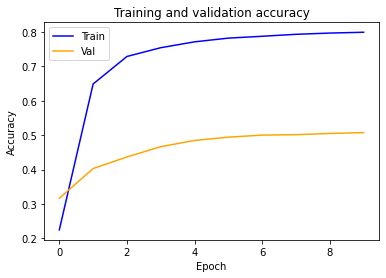

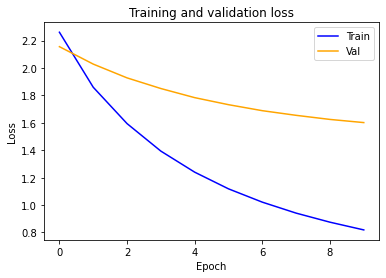

In [24]:
import matplotlib.pyplot as plt

# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

# Creating an Advanced Tunable Model for Classification on Int Vectorized Data

In [25]:
num_labels=11
def create_model(hp):
  # using hyperparameters that Keras will tune to decide features such as number of 
  # neurons, presence of layers, type of activation functions, etc. 
  num_units_embedding_conv1d = hp.Int('units',
                                        min_value=64,
                                        max_value=256,
                                        step=16)
  num_units_dense = hp.Int('units_1', min_value=16, max_value=32, step=4)
  activation_func = hp.Choice('activation_func', values=[1, 2])
  
  if (activation_func == 1):
    activation_function = 'relu'
  else:
    activation_function = 'sigmoid'
  
  additional_dense_layer = hp.Choice('additional_dense_layer', values=[1, 2])
  num_units_dense_2 = hp.Int('units_2', min_value=32, max_value=64, step=4)
  activation_func_2 = hp.Choice('activation_func_2', values=[1, 2])
  if (activation_func_2 == 1):
    activation_function_2 = 'relu'
  else:
    activation_function_2 = 'sigmoid'
  
  activation_func_embedding = hp.Choice('activation_func_3', values=[1, 2])
  if (activation_func_embedding == 1):
    activation_function_embedding = 'relu'
  else:
    activation_function_embedding = 'sigmoid'

  num_strides = hp.Int('strides', min_value=1, max_value=4, step=1)
  kernel_size = hp.Int('kernel_size', min_value=3, max_value=7, step=2)
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  pooling_layer = hp.Choice('pooling_layer', values=[1, 2])

  dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4, 0.5])

  if (pooling_layer == 1):
    global_pooling_layer = layers.GlobalMaxPooling1D()
  else:
    global_pooling_layer = layers.GlobalAveragePooling1D()
  
  if (additional_dense_layer == 2):
    model = tf.keras.Sequential([
        layers.Embedding(VOCAB_SIZE + 1, num_units_embedding_conv1d, mask_zero=True),
        layers.Conv1D(num_units_embedding_conv1d, kernel_size, padding="valid", activation=activation_function_embedding, strides=num_strides),
        global_pooling_layer,
        layers.Dense(num_units_dense, activation=activation_function),
        layers.Dropout(dropout_rate),
        layers.Dense(num_labels, activation='softmax')
    ])
  else:
    model = tf.keras.Sequential([
        layers.Embedding(VOCAB_SIZE + 1, num_units_embedding_conv1d, mask_zero=True),
        layers.Conv1D(num_units_embedding_conv1d, kernel_size, padding="valid", activation=activation_function_embedding, strides=num_strides),
        global_pooling_layer,
        layers.Dense(num_units_dense_2, activation=activation_function_2),
        layers.Dense(num_units_dense, activation=activation_function),
        layers.Dropout(dropout_rate),
        layers.Dense(num_labels, activation='softmax')
    ])
  model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy', 'mse', 'mean_squared_logarithmic_error', 'mean_absolute_error','cosine_similarity',tf.keras.metrics.LogCoshError(name='logcosh', dtype=None), tf.keras.metrics.KLDivergence(name='kullback_leibler_divergence', dtype=None)])
  return model

# Using Keras Autotuner to Find the Model with the Highest Validation Accuracy

In [27]:
import kerastuner as kt

tuner = kt.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=5)

tuner.search_space_summary()

Search space summary
Default search space size: 12
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 16, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 4, 'sampling': None}
activation_func (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
additional_dense_layer (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 4, 'sampling': None}
activation_func_2 (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
activation_func_3 (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
strides (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 7, 'step': 2, 'sampling': None}
l

In [28]:
# history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)
tuner.search(int_train_ds, validation_data=int_val_ds, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 450 Complete [00h 00m 57s]
val_accuracy: 0.61031174659729

Best val_accuracy So Far: 0.7326139211654663
Total elapsed time: 02h 33m 14s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 224
units_1: 24
activation_func: 2
additional_dense_layer: 2
units_2: 40
activation_func_2: 1
activation_func_3: 2
strides: 1
kernel_size: 5
learning_rate: 0.001
pooling_layer: 1
dropout_rate: 0.5
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 3bb19afd3f0ab9ebcbedd28483213ece
Score: 0.7326139211654663
Trial summary
Hyperparameters:
units: 208
units_1: 24
activation_func: 1
additional_dense_layer: 1
units_2: 40
activation_func_2: 1
activation_func_3: 1
strides: 4
kernel_size: 5
learning_rate: 0.001
pooling_layer: 1
dropout_rate: 0.5
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 642fae39802bdf4b933166c6ba03cf92
Score: 0.7314148545265198
Trial summary
Hyperparameters:
units: 256
units_1: 28
activation_func: 2
additional_dense_layer: 1
units_2: 32
activat

# Obtaining the Best Model and Hyperparameters

In [30]:
best_model = tuner.get_best_models(1)[0]

In [33]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]




# Change the name of the model being saved to avoid overwriting previous models. 
The last model saved was 'best_int_model_trial_4'

In [34]:
tf.keras.models.save_model(best_model, 'best_int_model_trial_4', overwrite=True, include_optimizer=True, save_traces=True)

INFO:tensorflow:Assets written to: best_int_model_trial_4/assets


In [37]:
loaded_model_1 = tf.keras.models.load_model('best_int_model_trial_1', compile=True)
loaded_model_2 = tf.keras.models.load_model('best_int_model_trial_2', compile=True)
loaded_model_3 = tf.keras.models.load_model('best_int_model_trial_3', compile=True)
int_metrics_1 = loaded_model_1.evaluate(int_test_ds)
int_metrics_2 = loaded_model_2.evaluate(int_test_ds)
int_metrics_3 = loaded_model_2.evaluate(int_test_ds)
int_metrics_4 = best_model.evaluate(int_test_ds)


loaded_model_1.summary()
print("Int model accuracy 1: {:2.2%}".format(int_metrics_1[1]))
print(int_metrics_1)
print('\n')
loaded_model_2.summary()
print("Int model accuracy 2: {:2.2%}".format(int_metrics_2[1]))
print(int_metrics_2)
print('\n')
loaded_model_3.summary()
print("Int model accuracy 3: {:2.2%}".format(int_metrics_3[1]))
print(int_metrics_3)
print('\n')
best_model.summary()
print("Int model accuracy 4: {:2.2%}".format(int_metrics_4[1]))
print(int_metrics_4)


118/118 [==============================] - 1s 9ms/step - loss: 1.0463 - accuracy: 0.6682 - mse: 33.4358 - mean_squared_logarithmic_error: 2.8247 - mean_absolute_error: 4.8974 - cosine_similarity: 1.2863 - logcosh: 4.2715 - kullback_leibler_divergence: 50.4692
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 112)         1120112   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 112)         62832     
_________________________________________________________________
global_max_pooling1d (Global (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1808      
_________________________________________________________________
dense_1 (Dense)              (None, 11)                187  

# Evaluating Different Models on Test Dataset

In [ ]:

int_metrics_1 = loaded_model_1.evaluate(int_test_ds)
int_metrics_2 = loaded_model_2.evaluate(int_test_ds)
int_metrics_3 = loaded_model_2.evaluate(int_test_ds)
int_metrics_4 = best_model.evaluate(int_test_ds)

print("Int model accuracy 1: {:2.2%}".format(int_metrics_1[1]))
print("Int model accuracy 2: {:2.2%}".format(int_metrics_2[1]))
print("Int model accuracy 3: {:2.2%}".format(int_metrics_3[1]))
print("Int model accuracy 4: {:2.2%}".format(int_metrics_4[1]))